# Bayesian version of Andrew Tyre’s Does model averaging make sense?

In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-darkgrid')
print('Runing on PyMC3 v{}'.format(pm.__version__))

Runing on PyMC3 v3.3


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


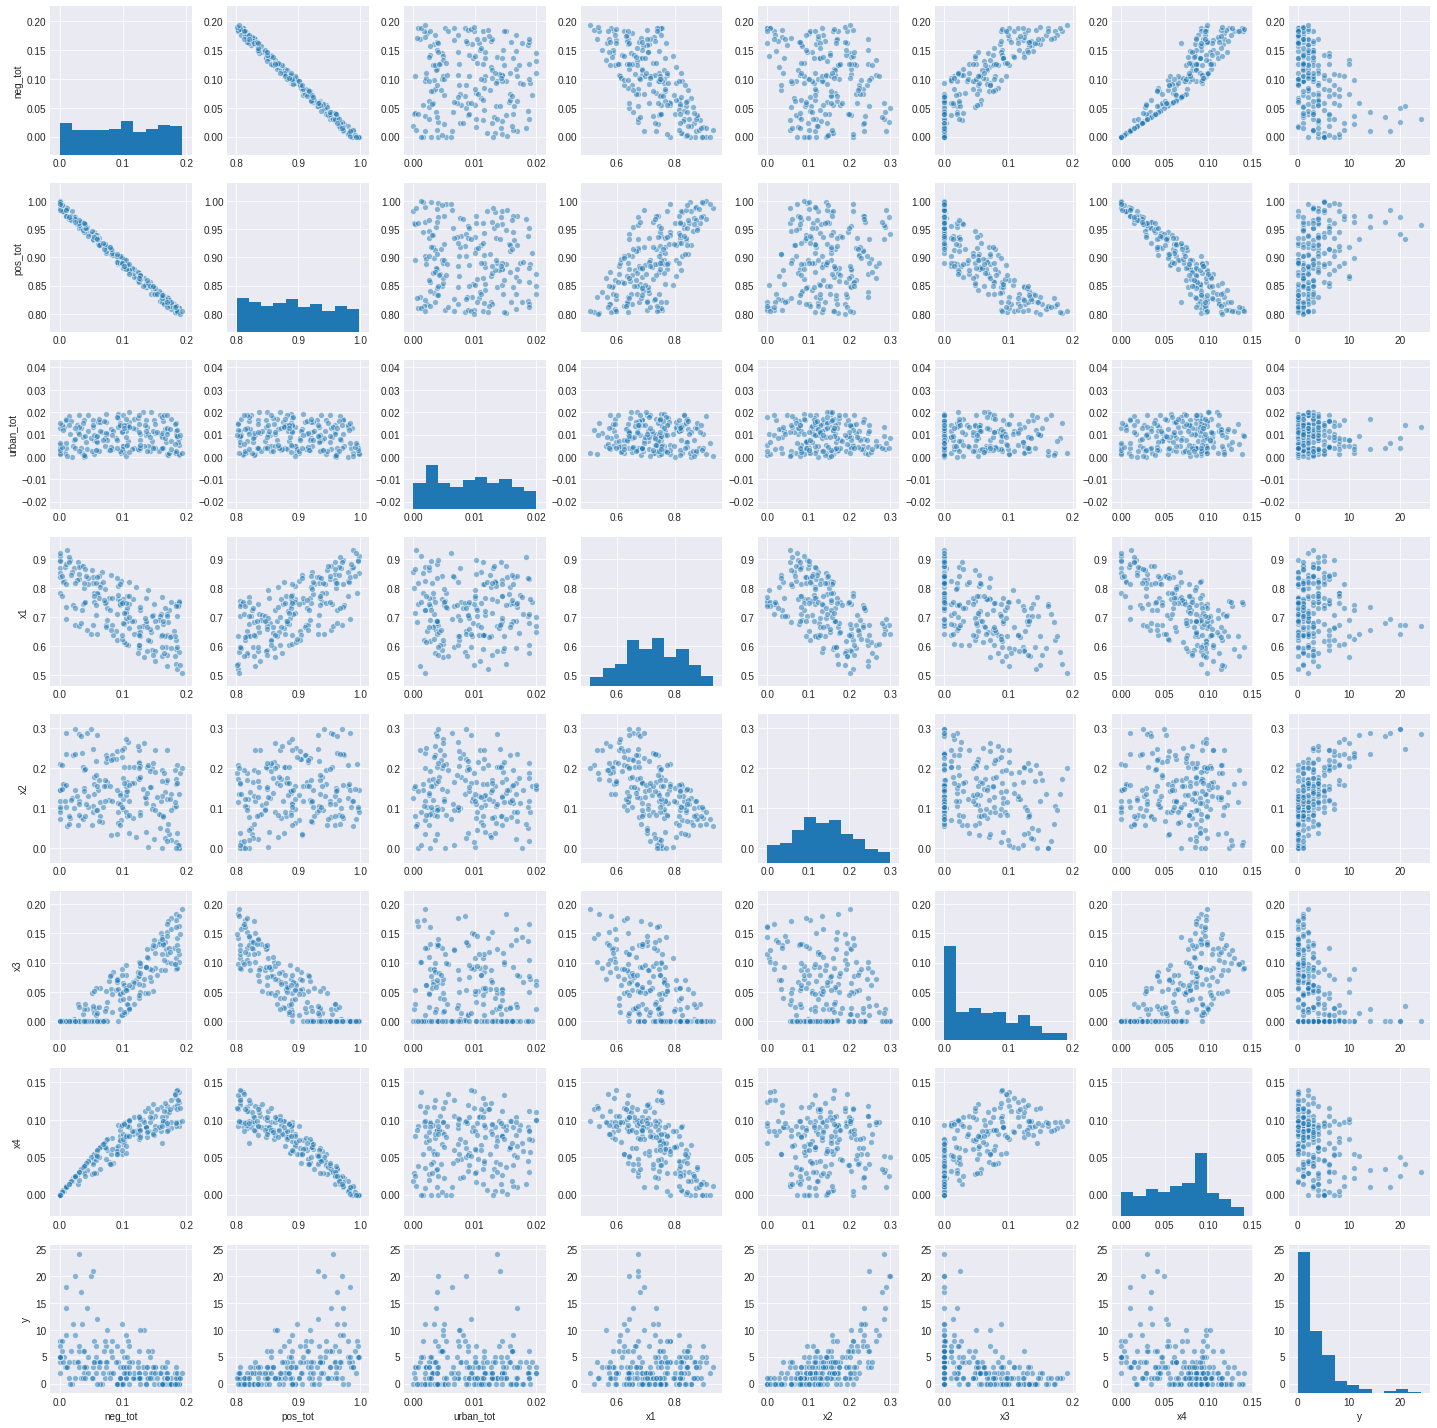

In [2]:
runif = np.random.uniform
pos_tot = runif(low=0.8, high=1.0, size=200)
urban_tot = np.min((runif(low=0., high=.02, size=200), 1.0 - pos_tot), axis=0)
neg_tot = 1.0 - np.min((pos_tot + urban_tot, np.ones(200)), axis=0)
x1 = np.max((pos_tot - runif(low=.05, high=.3, size=200), np.zeros(200)), axis=0)
x3 = np.max((neg_tot - runif(low=0., high=.1, size=200), np.zeros(200)), axis=0)
x2 = np.max((pos_tot - x1 - x3/2, np.zeros(200)), axis=0)
x4 = np.max((1 - x1 - x2 - x3 - urban_tot, np.zeros(200)), axis=0)
df = pd.DataFrame(
    dict(
        pos_tot=pos_tot,
        urban_tot=urban_tot,
        neg_tot=neg_tot,
        x1=x1, x2=x2, x3=x3, x4=x4
        )
    )
# true model and 200 Poisson observations
mean_y = np.exp(-5.8 + 6.3*df['x1'] + 15.2*df['x2'])
df['y'] = np.random.poisson(mean_y, size=200)

sns.pairplot(df, plot_kws={'alpha': .5});

In [3]:
scale = 2.5/np.std(df[['x1', 'x2', 'x3', 'x4']]).values

In [4]:
with pm.Model() as glmp:
    pm.glm.GLM.from_formula(
        'y ~ x1 + x2 + x3 + x4', data=df,
        priors=dict(Intercept=pm.Normal.dist(mu=0, sd=10),
                    x1=pm.Normal.dist(mu=0, sd=scale[0]),
                    x2=pm.Normal.dist(mu=0, sd=scale[1]),
                    x3=pm.Normal.dist(mu=0, sd=scale[2]),
                    x4=pm.Normal.dist(mu=0, sd=scale[3])),
        family=pm.glm.families.Poisson()
              )
glmp

In [5]:
with glmp:
    trace0 = pm.sample(1000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_log__, x4, x3, x2, x1, Intercept]
100%|██████████| 2000/2000 [01:21<00:00, 24.39it/s]
The acceptance probability does not match the target. It is 0.8976126187916706, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [6]:
pm.summary(trace0,
           varnames=['Intercept', 'x1', 'x2', 'x3', 'x4'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,2.327952,5.674314,0.223318,-7.789681,14.094654,580.207022,1.003256
x1,-2.123811,5.738668,0.225520,-13.378370,8.820892,583.027424,1.003250
x2,7.753760,5.669275,0.223638,-3.982995,17.897799,572.737225,1.003255
x3,-9.766738,5.767482,0.223108,-21.171354,1.219842,582.108365,1.003144
x4,-7.188616,6.046905,0.231467,-19.463843,4.238664,641.362590,1.002934


QR decomposition for the covariates. This part is not easy to do in glm module as we didnt implement a internal QR decomposition function.

In [7]:
import patsy
y, x = patsy.dmatrices('y ~ x1 + x2 + x3 + x4', df)
labels = x.design_info.column_names
X = np.asarray(x)[:, 1:]
Y = np.asarray(y)[:, -1]
q, r = np.linalg.qr(X)
Q = q*len(y)
R = r/len(y)
invR = np.linalg.inv(R)

In [25]:
with pm.Model() as glmp:
    b = pm.Normal('Intercept', mu=0., sd=10.)
    betas = pm.Normal('beta', mu=0., sd=2.5, shape=(4, 1))
    y_est = pm.math.exp(pm.math.dot(Q, betas)+b)
    y = pm.Poisson('y', mu=y_est.flatten(), observed=Y)

    mu_est = pm.math.dot(invR, betas)
    for i, il in enumerate(labels[1:]):
        pm.Deterministic(il, mu_est[i][0])

    trace0 = pm.sample(1000, tune=1000, cores=4, init=None)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, Intercept]
 19%|█▊        | 373/2000 [00:07<00:34, 47.46it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '11538' (I am process '11539')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '11538' (I am process '11540')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir
 33%|███▎      | 659/2000 [00:14<00:29, 45.60it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '11539' (I am process '11540')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir
100%|█████████

In [26]:
pm.summary(trace0,
           varnames=['Intercept', 'x1', 'x2', 'x3', 'x4'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,2.132638,5.445122,0.224847,-7.843324,13.348400,425.486043,1.002782
x1,-1.928188,5.509134,0.227053,-13.118749,8.216122,427.167460,1.002762
x2,7.946860,5.432616,0.224196,-2.811994,18.313825,424.220231,1.002817
x3,-9.609436,5.485016,0.222952,-21.012931,0.684732,441.866414,1.002829
x4,-6.944226,5.853569,0.238311,-18.365857,4.559329,442.589528,1.002507


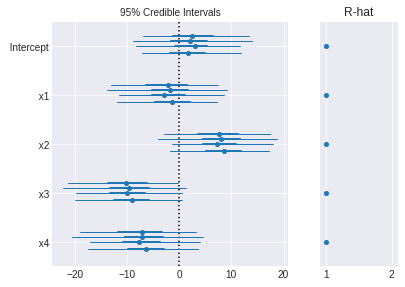

In [27]:
pm.forestplot(trace0,
           varnames=['Intercept', 'x1', 'x2', 'x3', 'x4']);

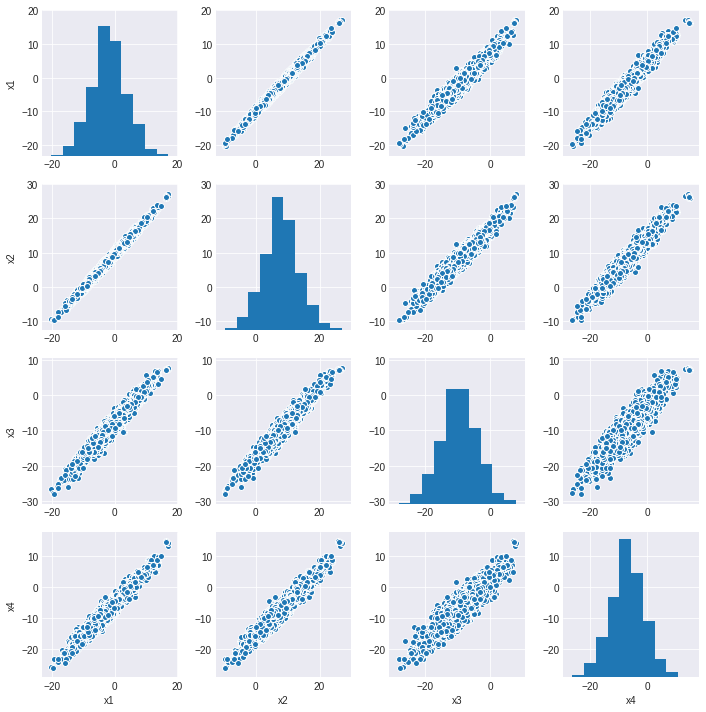

In [28]:
tracedf0 = pm.trace_to_dataframe(trace0,
                                 varnames=['x1', 'x2', 'x3', 'x4'])
sns.pairplot(tracedf0);

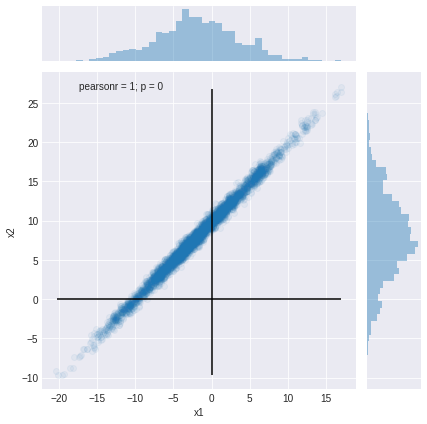

In [42]:
gs = sns.jointplot(tracedf0['x1'], tracedf0['x2'], kind='scatter', alpha=.05);
xmin, xmax = np.percentile(tracedf0['x1'], [.01, 99.99])
gs.ax_joint.hlines(0, xmin, xmax)
ymin, ymax = np.percentile(tracedf0['x2'], [.01, 99.99])
gs.ax_joint.vlines(0, ymin, ymax);

In [43]:
with pm.Model() as glmpnull:
    pm.glm.GLM.from_formula(
        'y ~ 1', data=df,
        priors=dict(Intercept=pm.Normal.dist(mu=0, sd=10)),
        family=pm.glm.families.Poisson()
              )
    trace_null = pm.sample(1000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_log__, Intercept]
100%|██████████| 2000/2000 [00:01<00:00, 1262.99it/s]


In [44]:
import loo

In [46]:
loo_p, pw = loo.loo(trace0, model=glmp)
loo_p

Computed from 4000 by 200 log-likelihood matrix


,Estimate,SE
elpd_loo,-364.486703,12.965731
p_loo,4.503716,0.672671
looic,728.973405,25.931462


In [48]:
df_nb = loo.ks_summary(pw['ks'])

All Pareto k estimates are good (k < 0.5)


In [47]:
loo_n, pw_null = loo.loo(trace_null, model=glmpnull)
loo_n

Computed from 4000 by 200 log-likelihood matrix


,Estimate,SE
elpd_loo,-646.802552,49.667907
p_loo,5.003407,1.029374
looic,1293.605105,99.335814


In [49]:
df_null = loo.ks_summary(pw_null['ks'])

All Pareto k estimates are good (k < 0.5)


In [51]:
compnew = loo.compare([pw_null, pw])
compnew.round(1)

,elpd_diff,se
m1-m0,282.3,46.3
